In [1]:
#import the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #For plotting
from sklearn.cluster import KMeans #Do K-Means clustering
from sklearn.metrics import silhouette_score #Calculate score of silhouette for each K
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator #Find the knee of the WCSS vs K plot
from yellowbrick.cluster import silhouette_visualizer #Plot Silhouette plot
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly
import plotly.express as px
import plotly.io as pio

In [10]:
import os
os.getcwd()

'C:\\Users\\nived\\OneDrive\\Documents\\GitHub\\seoulbike\\data_eda_location'

In [37]:
#Importing the dataset
office_data = pd.read_excel('../data/rental_office_(july_to_nov_2018).xlsx')
office_data.head()

,month,code,office,rentals,returns
0,201806,101,101. (구)합정동 주민센터,832,807
1,201806,102,102. 망원역 1번출구 앞,2819,2568
2,201806,103,103. 망원역 2번출구 앞,1977,1769
3,201806,104,104. 합정역 1번출구 앞,1682,1610
4,201806,105,105. 합정역 5번출구 앞,1105,925


In [38]:
office_data.drop(columns= ['month','office','code'],inplace=True) #these columns are not useful in our groupings 

In [39]:
office_data.describe() 

,rentals,returns
count,8038.000000,8038.000000
mean,864.065812,860.639836
std,725.979350,770.428084
min,0.000000,0.000000
25%,394.000000,362.000000
50%,693.000000,673.000000
75%,1127.000000,1140.000000
max,12207.000000,12332.000000


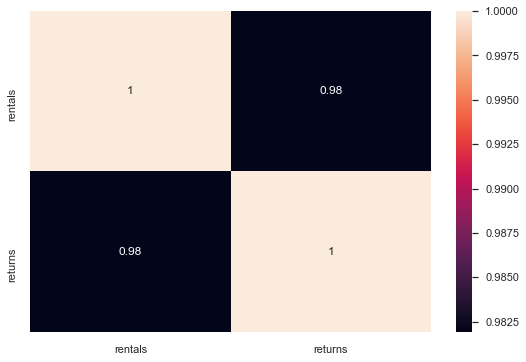

In [40]:
corrMatrix = office_data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

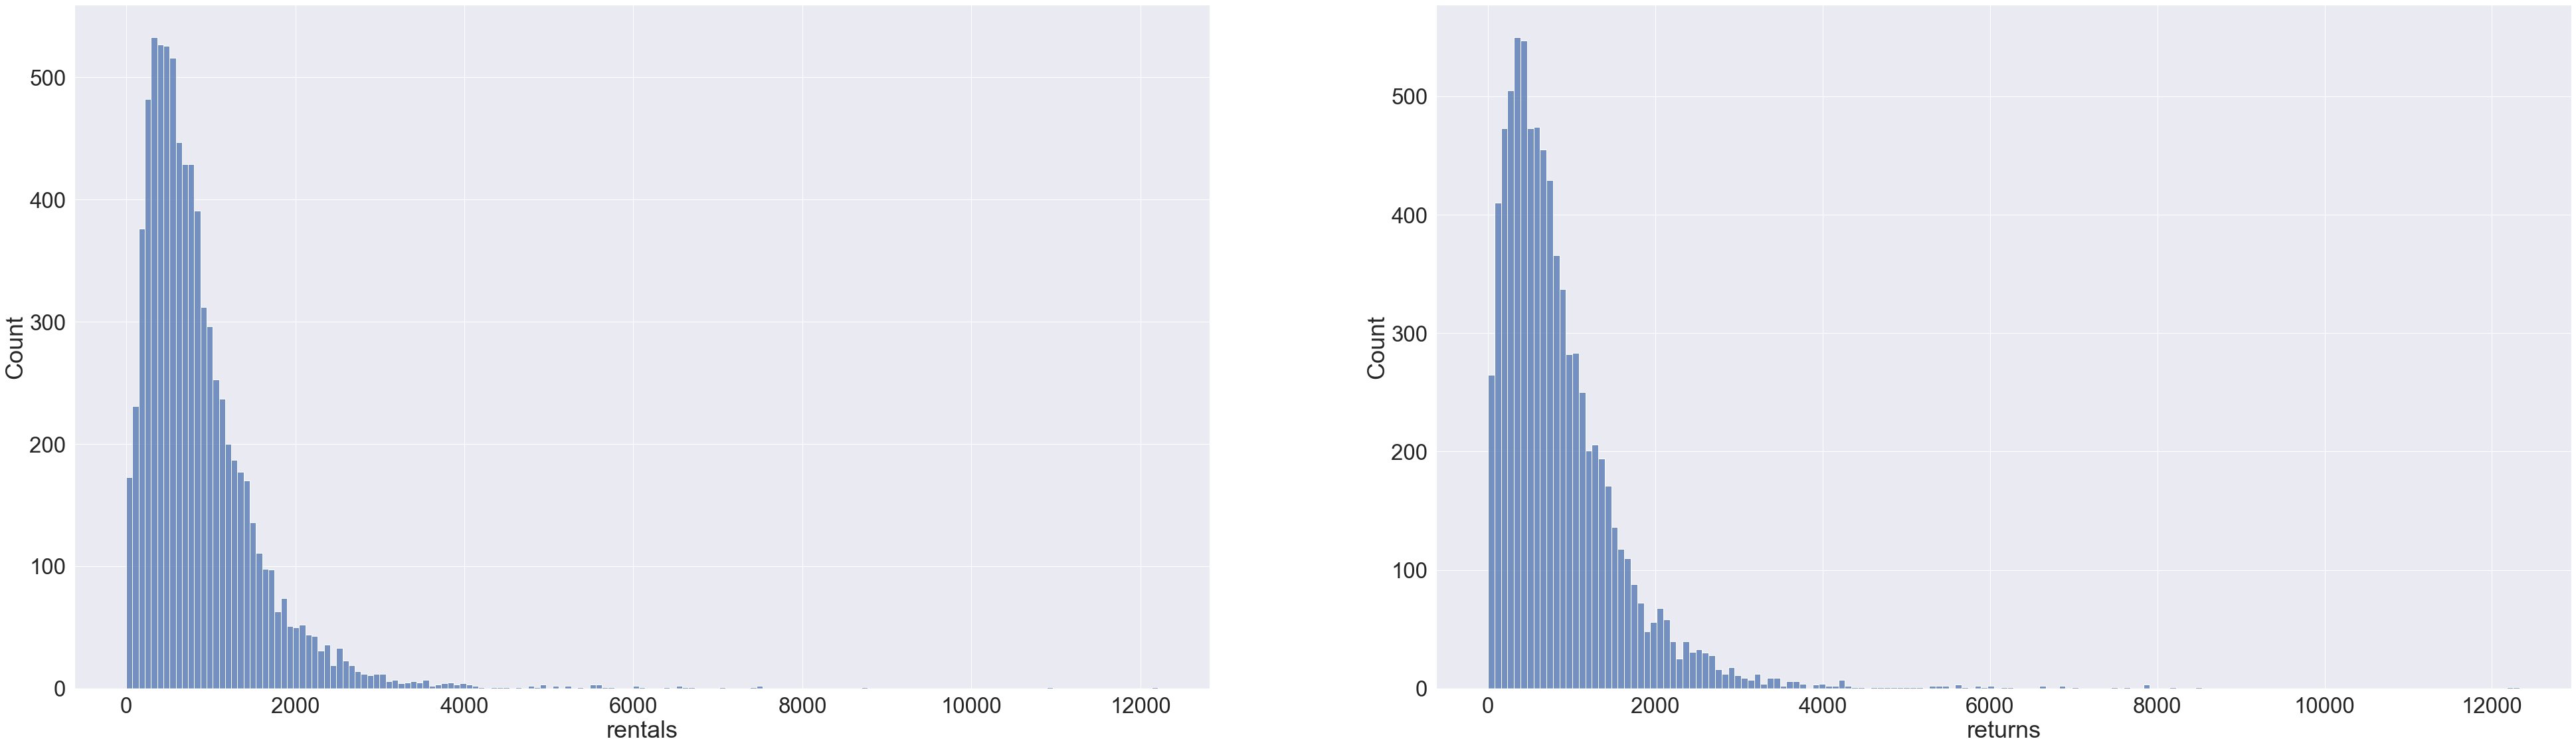

In [41]:
#Do a visual check to get a sense on how we can group some features
plt.figure(figsize=(60,60))
sns.set(font_scale = 3)
for i in range(len(office_data.columns)):
    plt.subplot(3,2,i+1)
    freshplot = sns.histplot(office_data.iloc[:,i])

In [42]:
#if the columns are too skewed, this is a method that scales each column of a dataframe, the output is a numpy array 
dataarray = office_data.to_numpy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataarray) #Scaling inputs if required

### Elbow method with Total WCSS vs Number of Clusters

In [43]:
wcss = []
max_k = 14 # NOTE: Try 10 and 20
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dataarray)
    wcss.append(kmeans.inertia_)

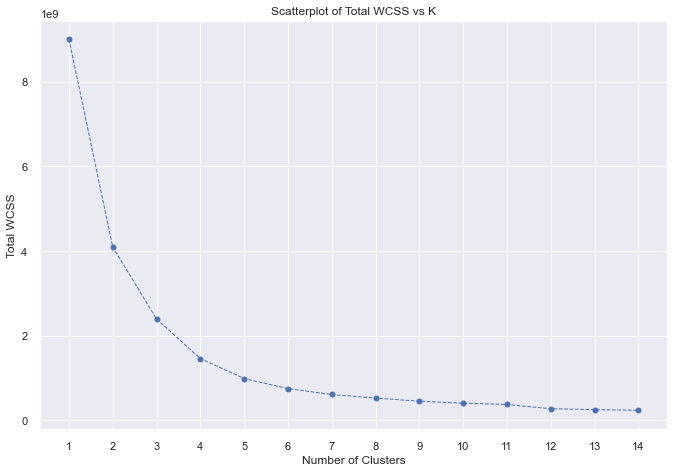

In [44]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [46]:
#To locate the elbow point of the curve using kneed package
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

kl.elbow

4

### Silhouette width plot

In [49]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dataarray)
    score = silhouette_score(dataarray, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

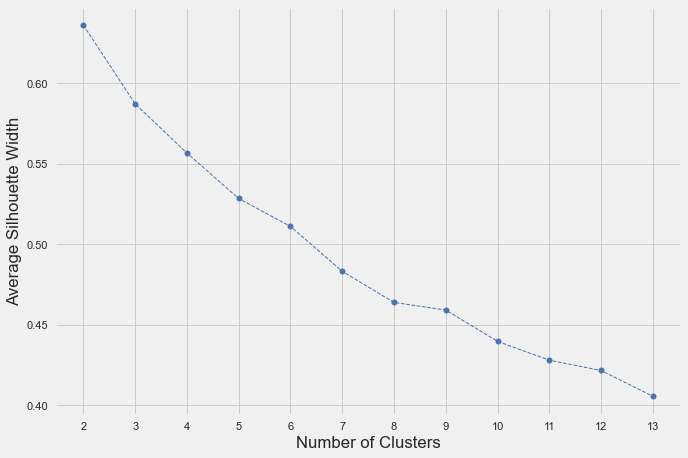

In [50]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

### Running the K-means on scaled data

In [51]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

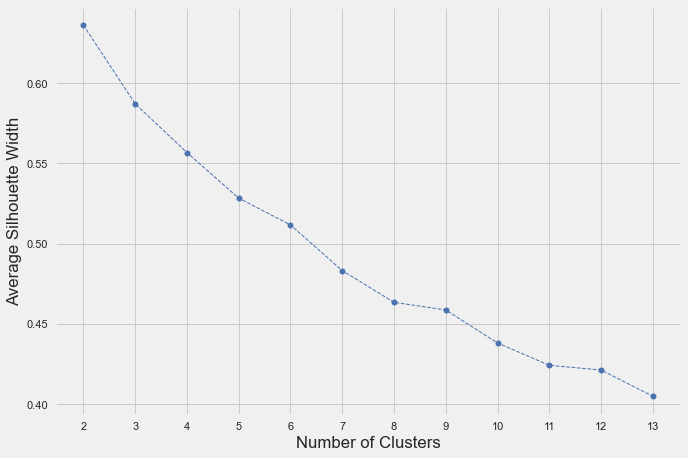

In [52]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

### K-Means Clustering Algorithm Implementation

In [53]:
#silhouette dictionary to track the silhouette scores for different k 
silhouette_dict = {}

In [54]:
#Fit kmeans labels onto our dataframe
#Input: df and int, Output:df 
def kmeans_label(data, num_clusters): 
  kmeans_model = KMeans(init = 'random', n_clusters = num_clusters, random_state=42)
  kmeans_model.fit(data.to_numpy())
  data2 = data.copy()
  labels = kmeans_model.labels_
  data2['Clusters'] = pd.DataFrame(labels)
  return data2

In [55]:
#Plot boxplots of each feature after attaching cluster label in each row
#Input: df with labels, Output: plt graphs
def plot_boxplots(data_with_label):
  plt.figure(figsize=(30,30))
  sns.set(font_scale = 2)
  for i in range(len(data_with_label.columns)-1):
    plt.subplot(3,3,i+1)
    sns.boxplot(y=data_with_label.columns[i], x='Clusters', data=data_with_label, palette="colorblind") 


In [56]:
#Plot the silhouettes
#Input: df, Output: plt graphs
def plot_silhouettes(data,num_clusters):
  dataarray = data.to_numpy()
  model = KMeans(num_clusters,random_state=42)
  plt.figure(figsize=(10, 7)) 
  sns.set(font_scale = 1)
  silhouette_visualizer(model, dataarray, colors='yellowbrick')
  score = silhouette_score(dataarray, model.labels_,metric = 'euclidean')
  if num_clusters not in silhouette_dict.keys():
    silhouette_dict[num_clusters] = score
  print("For n_clusters = {0} The average silhouette_score is: {1} ".format(num_clusters,score))


### KMeans with 4 clusters

In [57]:
kmeans4 = KMeans(init="random",n_clusters =4 , random_state = 42)
kmeans4.fit(dataarray)
clustergroups4 = kmeans4.labels_ #The cluster number for each row

In [61]:
Clustercenters4 = pd.DataFrame(kmeans4.cluster_centers_) #Dataframe of cluster centers
Clustercenters4.rename(columns={0: "Num_Rental", 1: "Num_Return"},inplace=True)
Clustercenters4.index.name = "Clusters"

In [62]:
Clustercenters4

,Num_Rental,Num_Return
Clusters,,
0,2175.825417,2244.388960
1,1108.473146,1120.532335
2,5242.573770,5595.836066
3,425.174849,394.799597


In [63]:
from decimal import Decimal
print(kmeans4.inertia_)
print('%.1E' % Decimal(kmeans4.inertia_))

1461288189.0243218
1.5E+09


In [64]:
model4 = kmeans_label(office_data, 4) #Attach kmeans_labels to our markets_data
model4.head() # which cluster each row belongs to

,rentals,returns,Clusters
0,832,807,2
1,2819,2568,3
2,1977,1769,3
3,1682,1610,2
4,1105,925,2


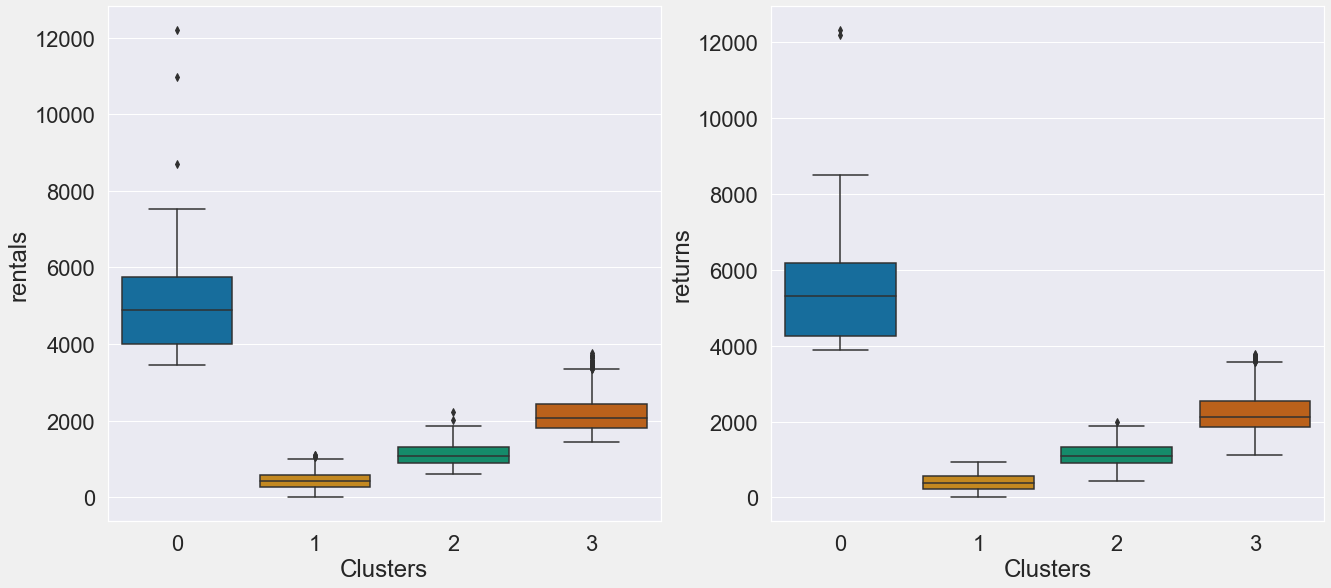

In [65]:
plot_boxplots(model4)

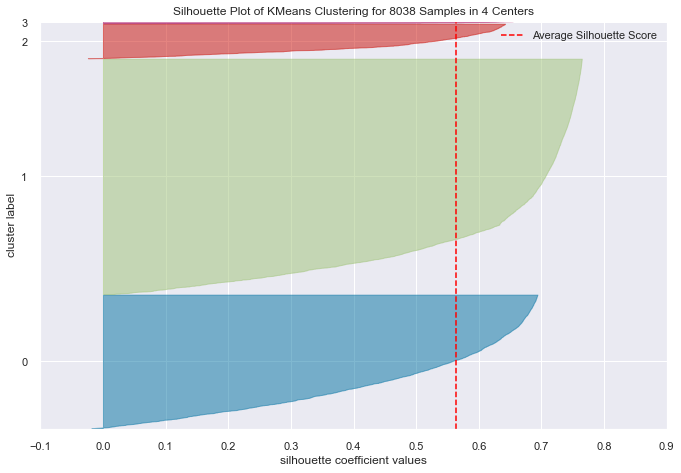

For n_clusters = 4 The average silhouette_score is: 0.564241474419612 


In [66]:
plot_silhouettes(office_data,4)

In [69]:
fig = px.scatter(model4, x='rentals', y='returns',
                    color='Clusters')
fig.show()